# Visual transformer on CIFAR10

Main ideas:
- convolution with kernel 3x3 before separation of the image into patches
- attention with relative position encoding as in CoAtNet, [arXiv:2106.04803 [cs.CV]](https://arxiv.org/abs/2106.04803)
- classification head with an additional nonlinearity and averge pooling

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 200

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1)
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

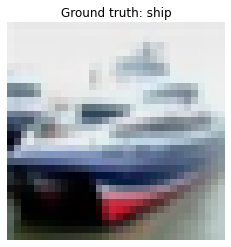

In [7]:
dataset_show_image(test_dset, 1)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

## Model

Utilities

In [9]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)

In [10]:
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

Transformer

Attention

$$
O = V \mathrm{softmax}\left[\frac{1}{\sqrt{c}}K^{\intercal}Q + R\right]
$$

In [11]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5
        
        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)
        
        height, width = shape
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))
    
    def forward(self, x):
        b, _, h, w = x.shape
        
        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)
        
        att = keys.transpose(-2, -1) @ queries
        
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))
        
        att = att * self.scale + rel_pos_enc
        att = F.softmax(att, dim=-2)
        
        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        return out
    
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing='ij')
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices

In [12]:
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1)   
        )

In [13]:
class TransformerBlock(nn.Sequential):
    def __init__(self, channels, head_channels, shape, p_drop=0.):
        super().__init__(
            Residual(
                LayerNormChannels(channels),
                SelfAttention2d(channels, channels, head_channels, shape),
                nn.Dropout(p_drop)
            ),
            Residual(
                LayerNormChannels(channels),
                FeedForward(channels, channels),
                nn.Dropout(p_drop)
            )
        )

In [14]:
class TransformerStack(nn.Sequential):
    def __init__(self, num_blocks, channels, head_channels, shape, p_drop=0.):
        layers = [TransformerBlock(channels, head_channels, shape, p_drop) for _ in range(num_blocks)]
        super().__init__(*layers)

Embedding of patches

In [15]:
class ToPatches(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, hidden_channels=32):
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, channels, patch_size, stride=patch_size)
        )

In [16]:
class AddPositionEmbedding(nn.Module):
    def __init__(self, channels, shape):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(channels, *shape))
    
    def forward(self, x):
        return x + self.pos_embedding

In [17]:
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, shape, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, channels, patch_size),
            AddPositionEmbedding(channels, shape),
            nn.Dropout(p_drop)
        )

Main model

In [18]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [19]:
class RelViT(nn.Sequential):
    def __init__(self, classes, image_size, channels, head_channels, num_blocks, patch_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        super().__init__(
            ToEmbedding(in_channels, channels, patch_size, shape, emb_p_drop),
            TransformerStack(num_blocks, channels, head_channels, shape, trans_p_drop),
            Head(channels, classes, head_p_drop)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, SelfAttention2d):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)
    
    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv2d)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, SelfAttention2d) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

In [20]:
model = RelViT(NUM_CLASSES, IMAGE_SIZE, channels=256, head_channels=32, num_blocks=8, patch_size=2,
               emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)

In [21]:
model.to(DEVICE);

In [22]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,482,138


## CutMix

In [23]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [24]:
class CutMix(nn.Module):
    def __init__(self, loss, α=1.0):
        super().__init__()
        self.loss = loss
        self.α = α
        self.rng = np.random.default_rng()
    
    def prepare_batch(self, batch, device, non_blocking):
        x, y = batch
        x = convert_tensor(x, device=device, non_blocking=non_blocking)
        y = convert_tensor(y, device=device, non_blocking=non_blocking)
        
        batch_size = x.size(0)
        self.index = torch.randperm(batch_size).to(device)
        
        self.λ = self.rng.beta(self.α, self.α)
        y1, x1, y2, x2 = self.cut_bounding_box(x.shape[-2:], self.λ)
        x[:, :, y1:y2, x1:x2] = x[self.index, :, y1:y2, x1:x2]
                
        # adjust lambda to exactly match pixel ratio
        area = x.size(2) * x.size(3)
        self.λ = 1. - (x2 - x1) * (y2 - y1) / area
        return x, y
    
    def cut_bounding_box(self, shape, λ):
        cut_size_2 = 0.5 * np.sqrt(1. - λ)
        center_yx = self.rng.random(2)
        
        y1x1 = (np.clip(center_yx - cut_size_2, 0., 1.) * shape).astype(int)
        y2x2 = (np.clip(center_yx + cut_size_2, 0., 1.) * shape).astype(int)
        return np.concatenate((y1x1, y2x2))
        
    def forward(self, pred, target):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, target) + (1. - self.λ) * self.loss(pred, target[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)

## Training

### Optimizer

In [25]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [26]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

In [27]:
cutmix = CutMix(loss, α=1.0)

In [28]:
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [29]:
trainer = create_supervised_trainer(model, optimizer, cutmix, device=DEVICE, prepare_batch=cutmix.prepare_batch)

In [30]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [31]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [32]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [33]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [34]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [35]:
history = defaultdict(list)

In [36]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [39]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/200 - train: loss 2.203; val: loss 2.018 accuracy 0.299
2/200 - train: loss 2.143; val: loss 1.856 accuracy 0.368
3/200 - train: loss 2.111; val: loss 1.757 accuracy 0.448
4/200 - train: loss 2.042; val: loss 1.635 accuracy 0.484
5/200 - train: loss 2.033; val: loss 1.530 accuracy 0.549
6/200 - train: loss 1.980; val: loss 1.472 accuracy 0.553
7/200 - train: loss 1.945; val: loss 1.435 accuracy 0.576
8/200 - train: loss 1.950; val: loss 1.382 accuracy 0.607
9/200 - train: loss 1.948; val: loss 1.388 accuracy 0.611
10/200 - train: loss 1.896; val: loss 1.351 accuracy 0.620
11/200 - train: loss 1.915; val: loss 1.356 accuracy 0.614
12/200 - train: loss 1.917; val: loss 1.309 accuracy 0.648
13/200 - train: loss 1.875; val: loss 1.258 accuracy 0.662
14/200 - train: loss 1.902; val: loss 1.265 accuracy 0.675
15/200 - train: loss 1.867; val: loss 1.261 accuracy 0.660
16/200 - train: loss 1.830; val: loss 1.230 accuracy 0.678
17/200 - train: loss 1.874; val: loss 1.215 accuracy 0.692
18/200

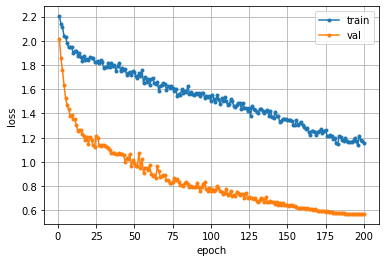

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

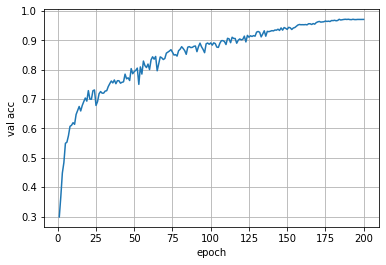

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()

## Model without attention

Only input-independent weights (relative position encoding) remain:

In [11]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5
        
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)
        
        height, width = shape
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))
    
    def forward(self, x):
        b, _, h, w = x.shape
        
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))
        
        att = F.softmax(rel_pos_enc, dim=-2)
        
        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        return out
    
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing='ij')
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices

In [22]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 5,429,466


### Start training

In [37]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/200 - train: loss 2.248; val: loss 2.092 accuracy 0.262
2/200 - train: loss 2.203; val: loss 1.968 accuracy 0.318
3/200 - train: loss 2.155; val: loss 1.874 accuracy 0.350
4/200 - train: loss 2.121; val: loss 1.838 accuracy 0.374
5/200 - train: loss 2.093; val: loss 1.768 accuracy 0.404
6/200 - train: loss 2.068; val: loss 1.691 accuracy 0.472
7/200 - train: loss 2.027; val: loss 1.597 accuracy 0.502
8/200 - train: loss 2.013; val: loss 1.560 accuracy 0.519
9/200 - train: loss 2.019; val: loss 1.539 accuracy 0.518
10/200 - train: loss 1.979; val: loss 1.484 accuracy 0.559
11/200 - train: loss 1.991; val: loss 1.443 accuracy 0.580
12/200 - train: loss 1.925; val: loss 1.406 accuracy 0.607
13/200 - train: loss 1.920; val: loss 1.411 accuracy 0.592
14/200 - train: loss 1.949; val: loss 1.398 accuracy 0.591
15/200 - train: loss 1.903; val: loss 1.333 accuracy 0.629
16/200 - train: loss 1.872; val: loss 1.272 accuracy 0.666
17/200 - train: loss 1.865; val: loss 1.273 accuracy 0.665
18/200

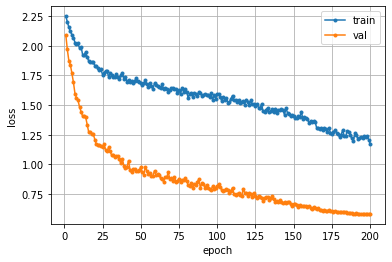

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

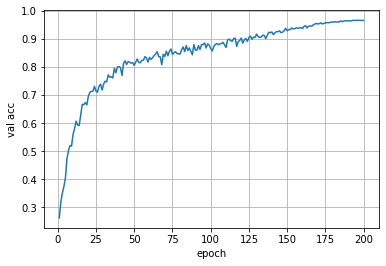

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()